In [41]:
!/opt/bin/nvidia-smi
!ps -aux|grep python
!kill -9 651

Wed Mar  4 09:32:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    33W / 250W |   9015MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [42]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST'
sys.path.append(base_dir)

Mounted at /content/gdrive/


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import preconditioned_stochastic_gradient_descent as psgd 
from tabulate import tabulate
import scipy.io

## Download MNIST Data

In [44]:
"""MNIST, classification"""
np.random.seed(0)

# Parameter Settings
batch_size = 128
num_f = 32  # number of features 

dtype = tf.float32

mnist = tf.contrib.learn.datasets.load_dataset('mnist')

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [45]:
train_data = np.concatenate((mnist.train.images, mnist.validation.images), axis = 0)

print('total images:',train_data.shape[0])
print('training images:',mnist.train.images.shape[0])
print('validation images:',mnist.validation.images.shape[0])
print('number of features:',mnist.validation.images.shape[1])

# reshape data as 28x28x1 image 
train_data = np.reshape(2.0*train_data - 1.0, [60000, 28, 28, 1])

#binarize the labels
train_label = np.zeros([60000, 10])
train_label[np.arange(60000), np.concatenate((mnist.train.labels, mnist.validation.labels), axis = 0)] = 1.0

test_label = np.zeros([10000, 10])
test_label[np.arange(10000), mnist.test.labels] = 1.0


total images: 60000
training images: 55000
validation images: 5000
number of features: 784


In [0]:
def get_batches():
    # generate 60000 numbers randomly without replacement
    rp = np.random.permutation(train_data.shape[0])
    x = -np.ones([batch_size, 32, 32, 1])
    
    # augumentation: randomly shifting image by +-2 pixels 
    for i in range(batch_size):
        m = math.floor(5.0*np.random.rand())
        n = math.floor(5.0*np.random.rand())
        x[i, m:m+28, n:n+28] = train_data[rp[i]]
    y = train_label[rp[0:batch_size]]
    return x, y

## Defining CNN model for training.
The model consists of 2 convolutional layers, 1 avgpool layer, 2 convolutional layers, 1 avg pool layer, 1 FC layer, 1 FC layer.

In [0]:
train_inputs = tf.placeholder(dtype, [batch_size, 32, 32, 1])
train_outputs = tf.placeholder(dtype, [batch_size, 10])
adam_step = tf.placeholder(tf.float32, shape = ())

In [0]:
# (hight, width, in_ch, out_ch) tensor --> (hight * width * in_ch, out_ch) matrix 
W1 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*1+1), size=[3*3*1+1, num_f]), dtype=dtype)
W2 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W3 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W4 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(3*3*num_f+1), size=[3*3*num_f+1, num_f]), dtype=dtype)
W5 = tf.Variable(np.random.normal(loc=0.0, scale=1.0/np.sqrt(5*5*num_f+1), size=[5*5*num_f+1, 10]), dtype=dtype)
Ws = [W1, W2, W3, W4, W5]

# we use the traditional tanh
def model(Ws, inputs):
    
    W1, W2, W3, W4, W5 = Ws
    w1 = tf.reshape(W1[:-1], [3, 3, 1, num_f])
    b1 = W1[-1]
    x1 = tf.tanh( tf.nn.conv2d(input = inputs,filters = w1, strides = [1,1,1,1], padding = 'VALID') + b1 )
    
        
    w2 = tf.reshape(W2[:-1], [3, 3, num_f, num_f])
    b2 = W2[-1]
    x2 = tf.tanh( tf.nn.conv2d(input = x1, filters = w2, strides = [1,1,1,1], padding = 'VALID') + b2 )
    
    x2 = tf.nn.avg_pool(value = x2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
        
    w3 = tf.reshape(W3[:-1], [3, 3, num_f, num_f])
    b3 = W3[-1]
    x3 = tf.tanh( tf.nn.conv2d(x2, w3, [1,1,1,1], 'VALID') + b3 )
        
    w4 = tf.reshape(W4[:-1], [3, 3, num_f, num_f])
    b4 = W4[-1]
    x4 = tf.tanh( tf.nn.conv2d(x3, w4, [1,1,1,1], 'VALID') + b4 )
    
    x4 = tf.nn.avg_pool(value = x4, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    batch_size = inputs.shape.as_list()[0]
    x4_flat = tf.reshape(x4, [batch_size, -1])
    ones = tf.ones([batch_size, 1], dtype=dtype)
    y = tf.matmul(tf.concat([x4_flat, ones], axis = 1), W5)
    return y


## Define cross entropy as Training Loss function (Loss function) and Test Loss function

In [0]:
# cross entropy loss
def train_criterion(Ws):
    y = model(Ws, train_inputs)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=train_outputs, logits=y))


test_data = -np.ones([10000, 32, 32, 1])
test_data[:,2:30,2:30] = np.reshape(2.0*mnist.test.images - 1.0, [10000, 28, 28, 1])

test_outputs = mnist.test.labels
# classification error rate
def test_criterion(Ws):
    y = model(Ws, tf.constant(test_data, dtype=dtype))
    # return 1 - accuracy 
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=test_label, logits=y))
    # return 1.0 - tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=1), tf.constant(mnist.test.labels, dtype=tf.int64)), dtype=dtype))

# SGD

train loss: 2.34708309173584; test loss: 2.3296093940734863; time:0.12131333351135254
train loss: 2.0725589592099194; test loss: 1.617577314376831; time:0.6369106769561768
train loss: 1.7166134552020886; test loss: 1.0128201246261597; time:1.1409988403320312
train loss: 1.3759023326232935; test loss: 0.756305456161499; time:1.6638097763061523
train loss: 1.1684378706016854; test loss: 0.6244770288467407; time:2.168332576751709
train loss: 1.0434762199597807; test loss: 0.5582276582717896; time:2.683367967605591
train loss: 0.9573945867416255; test loss: 0.5254155397415161; time:3.1902315616607666
train loss: 0.9045350844031511; test loss: 0.4793718755245209; time:3.689201593399048
train loss: 0.8640027179625231; test loss: 0.45693838596343994; time:4.189289093017578
train loss: 0.8247415775879517; test loss: 0.42931637167930603; time:4.698648691177368
train loss: 0.785455489573514; test loss: 0.40827271342277527; time:5.198549747467041
train loss: 0.7403434565656268; test loss: 0.38916

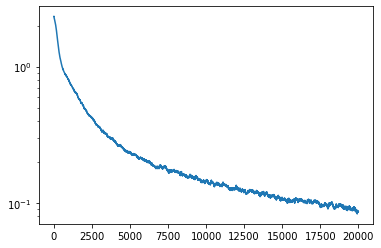

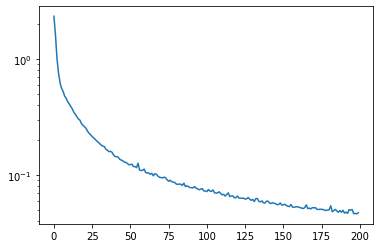

In [50]:
step_size = 0.01
grad_norm_clip_thr = 1e0 # may need gradients cliping for RNN training; otherwise, set it to an extremely large value  

with tf.Session() as sess:
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    test_loss = test_criterion(Ws)

    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _ = sess.run([train_loss, update_Ws],
                                  {train_inputs: _train_inputs, train_outputs: _train_outputs})     
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; time:{}'.format(TrainLoss[-1],TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

 
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/SGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ADAM

train loss: 2.3280444145202637; test loss: 2.21090030670166; Time: 0.13658761978149414
train loss: 0.7048925857469441; test loss: 0.12462034821510315; Time: 0.7080860137939453
train loss: 0.38042892064272155; test loss: 0.08065993338823318; Time: 1.2788784503936768
train loss: 0.22402496234138697; test loss: 0.060760680586099625; Time: 1.851140022277832
train loss: 0.15585732103701408; test loss: 0.05350077524781227; Time: 2.4354629516601562
train loss: 0.12470251808798179; test loss: 0.07369834184646606; Time: 3.006354570388794
train loss: 0.10664118150528484; test loss: 0.05391724780201912; Time: 3.5700650215148926
train loss: 0.10306647057996939; test loss: 0.058440882712602615; Time: 4.137842178344727
train loss: 0.10702710617076827; test loss: 0.05784688889980316; Time: 4.696033477783203
train loss: 0.0921531976744103; test loss: 0.04787435755133629; Time: 5.2623655796051025
train loss: 0.08891299759158074; test loss: 0.04016098007559776; Time: 5.818512678146362
train loss: 0.0821

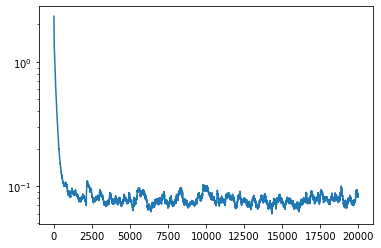

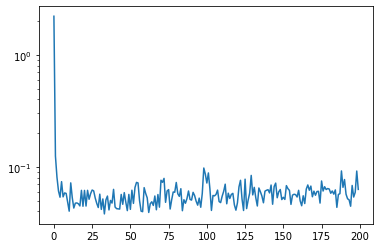

In [51]:
# Adam 
step_size = 0.005
beta1 = 0.9
beta2 = 0.999
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_moment = [beta1*m + (1.0 - beta1)*g for (m, g) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*v + (1.0 - beta2)*g*g for (v, g) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]
          
    new_Ws = [W - step_size*m/(tf.sqrt(v) + offset) for (W, m, v) in zip(Ws, new_grads_moment_hat, new_grads_vars_hat)]
  
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t = t + 1
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_grads_moment],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step:t})  
        
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# ESGD

train loss: 2.3419744968414307; test loss: 2.339838981628418; Time: 0.2279510498046875
train loss: 1.8423180395483951; test loss: 1.0184601545333862; Time: 1.4349853992462158
train loss: 1.3703417590989626; test loss: 0.6120250225067139; Time: 2.640843152999878
train loss: 1.0971308477309583; test loss: 0.49981439113616943; Time: 3.844428777694702
train loss: 0.939609395883389; test loss: 0.44101816415786743; Time: 5.047593355178833
train loss: 0.8252770105038932; test loss: 0.38327327370643616; Time: 6.2366862297058105
train loss: 0.7222158771130539; test loss: 0.34083130955696106; Time: 7.432756423950195
train loss: 0.6398732711056937; test loss: 0.29889976978302; Time: 8.643787145614624
train loss: 0.5719891519129399; test loss: 0.2669958472251892; Time: 9.845882892608643
train loss: 0.5115039339182335; test loss: 0.23978032171726227; Time: 11.052711248397827
train loss: 0.45014510328574586; test loss: 0.21559013426303864; Time: 12.246302127838135
train loss: 0.4071276742667784; tes

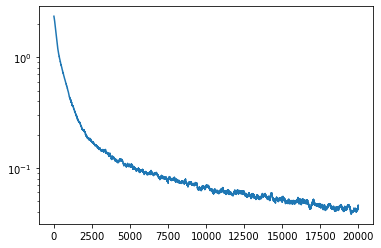

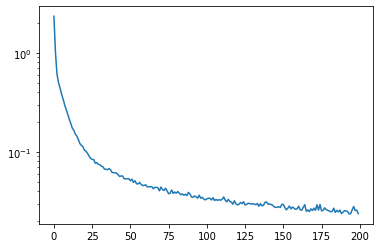

In [52]:
step_size = 0.02
grad_norm_clip_thr = 1e0
max_mu = 0.99 
offset = 1e-9 
         
with tf.Session() as sess:
    dws2 = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws] # delta_W**2
    dgs2 = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws] # delta_grad**2
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for dws2, dgs2 estimation
        
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)]) # grads * delta_Ws
    hess_deltaw = tf.gradients(grad_deltaw, Ws) # Hessian * delta_Ws

    new_dws2 = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(dws2, delta_Ws)]    
    new_dgs2 = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(dgs2, hess_deltaw)]
    
    precond_grads = [g*tf.sqrt(dw/(dg + offset)) for (g, dw, dg) in zip(grads, new_dws2, new_dgs2)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_dws2 = [tf.assign(old, new) for (old, new) in zip(dws2, new_dws2)]
    update_dgs2 = [tf.assign(old, new) for (old, new) in zip(dgs2, new_dgs2)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)  
       
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _,_,_,_ = sess.run([train_loss, update_Ws, update_dws2, update_dgs2, update_mu],
                                        {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))
    
    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/ESGD.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# SGD with RMSprop

train loss: 2.3421406745910645; test loss: 2.2795088291168213; Time: 0.15971922874450684
train loss: 1.2410921901822096; test loss: 0.48357176780700684; Time: 0.7165381908416748
train loss: 0.918059095700082; test loss: 0.32486552000045776; Time: 1.2791876792907715
train loss: 0.6568407947289667; test loss: 0.24527619779109955; Time: 1.846261739730835
train loss: 0.4665790990134522; test loss: 0.1639091670513153; Time: 2.4030590057373047
train loss: 0.34487487736266786; test loss: 0.13665397465229034; Time: 2.974285364151001
train loss: 0.27147870351494074; test loss: 0.10692092031240463; Time: 3.5297653675079346
train loss: 0.21985485522383344; test loss: 0.09929750859737396; Time: 4.078590393066406
train loss: 0.19698931143789805; test loss: 0.08040840178728104; Time: 4.614866733551025
train loss: 0.1667942093986766; test loss: 0.07575021684169769; Time: 5.159148931503296
train loss: 0.15156041711642246; test loss: 0.07323352992534637; Time: 5.703305244445801
train loss: 0.1383329823

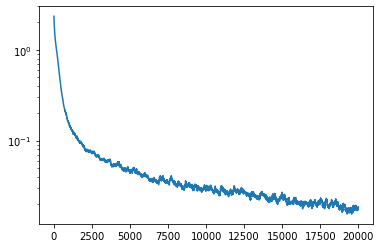

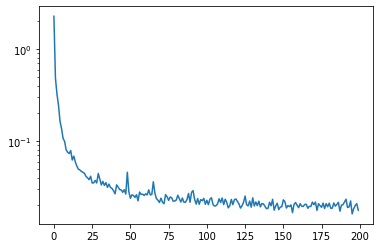

In [53]:
# RMSProp  
step_size = 0.0005
max_mu = 0.99
offset = 1e-9
         
with tf.Session() as sess:
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    mu = tf.Variable(initial_value=0.0, trainable=False, dtype=dtype) # forgetting factor for grads**2 estimation 
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    new_grads_vars = [mu*old + (1.0 - mu)*new*new for (old, new) in zip(grads_vars, grads)]
    new_Ws = [W - step_size*g/tf.sqrt(v + offset) for (W, g, v) in zip(Ws, grads, new_grads_vars)]
    new_mu = tf.minimum(max_mu, 1.0/(2.0 - mu))
    
    update_Ws = [tf.assign(old, new) for (old, new) in zip(Ws, new_Ws)]
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_mu = tf.assign(mu, new_mu)
    
    test_loss = test_criterion(Ws)
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
     
        t0 = time.time()
        _train_loss, _,_,_ = sess.run([train_loss, update_Ws, update_grads_vars, update_mu],
                                      {train_inputs: _train_inputs, train_outputs: _train_outputs})  
        Time.append(time.time() - t0)
        
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/rmsprop.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss,'Time':Time})

# PSGD with Kronecker Product Preconditioning

train loss: 2.355283737182617; test loss: 2.2887983322143555; Time: 0.3353538513183594
train loss: 1.3231899953842161; test loss: 0.5032183527946472; Time: 1.8623738288879395
train loss: 0.9375615925454691; test loss: 0.3140855133533478; Time: 3.39449405670166
train loss: 0.6192992411299427; test loss: 0.17939680814743042; Time: 4.926277160644531
train loss: 0.4022035232783592; test loss: 0.12271305918693542; Time: 6.471469879150391
train loss: 0.2786376388113063; test loss: 0.09476860612630844; Time: 8.001819849014282
train loss: 0.20968641728325232; test loss: 0.07895295321941376; Time: 9.543328523635864
train loss: 0.16595949551168507; test loss: 0.067652627825737; Time: 11.069865942001343
train loss: 0.13839067619508716; test loss: 0.05822603777050972; Time: 12.59632420539856
train loss: 0.12067948754503162; test loss: 0.05207696557044983; Time: 14.141720056533813
train loss: 0.10891711235007066; test loss: 0.04809422791004181; Time: 15.680866718292236
train loss: 0.099945701094925

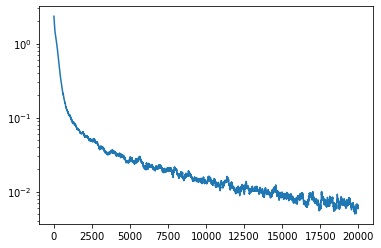

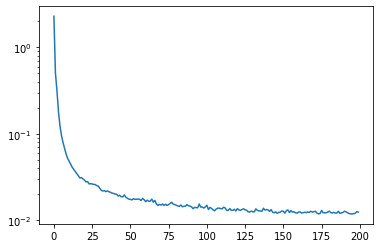

In [54]:
step_size = 0.05
# grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  
grad_norm_clip_thr = 1e0
with tf.Session() as sess:   
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, hess_deltaw)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time': Time})

# PSGD with Kronecker Product Preconditioning (Approximated H*v product)

train loss: 2.348782539367676; test loss: 2.2990262508392334, time:0.26512646675109863
train loss: 1.3274453690886503; test loss: 0.5152470469474792, time:1.5032308101654053
train loss: 0.960112776234948; test loss: 0.31965914368629456, time:2.7472095489501953
train loss: 0.63112831677358; test loss: 0.18109142780303955, time:3.9763591289520264
train loss: 0.40649990347288173; test loss: 0.12452787905931473, time:5.208850145339966
train loss: 0.2766250631867637; test loss: 0.09718375653028488, time:6.430816411972046
train loss: 0.20647436748694487; test loss: 0.07882020622491837, time:7.68171238899231
train loss: 0.16446145045146177; test loss: 0.0668659582734108, time:8.924633741378784
train loss: 0.14156279941451058; test loss: 0.05863640829920769, time:10.161604642868042
train loss: 0.1225244269317495; test loss: 0.053501710295677185, time:11.401466369628906
train loss: 0.10653230195317501; test loss: 0.04780197888612747, time:12.651384592056274
train loss: 0.09919736675808415; test

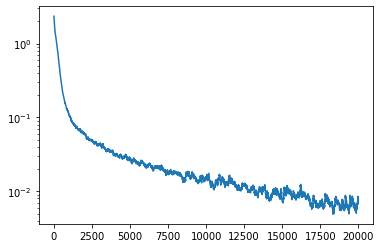

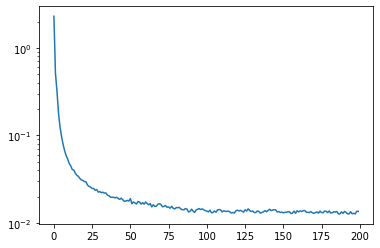

In [55]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_Qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SPLU

train loss: 2.321030616760254; test loss: 2.2982215881347656; Time: 0.3145880699157715
train loss: 1.4213305946886527; test loss: 0.5964012742042542; Time: 1.6093671321868896
train loss: 1.0545725922053337; test loss: 0.44010868668556213; Time: 2.9003868103027344
train loss: 0.8405502871295774; test loss: 0.3544633984565735; Time: 4.1916184425354
train loss: 0.6766849813791892; test loss: 0.2767602503299713; Time: 5.481592893600464
train loss: 0.547007170699133; test loss: 0.22487691044807434; Time: 6.784361839294434
train loss: 0.43749229912444565; test loss: 0.18679951131343842; Time: 8.071220636367798
train loss: 0.3650607146239423; test loss: 0.16784660518169403; Time: 9.360464811325073
train loss: 0.3093791512254592; test loss: 0.1457327902317047; Time: 10.648771047592163
train loss: 0.27350242151582826; test loss: 0.13110308349132538; Time: 11.933180809020996
train loss: 0.250109879232555; test loss: 0.1156911849975586; Time: 13.21740174293518
train loss: 0.2294082429763557; test

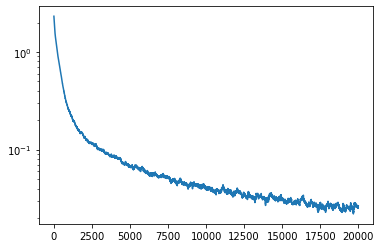

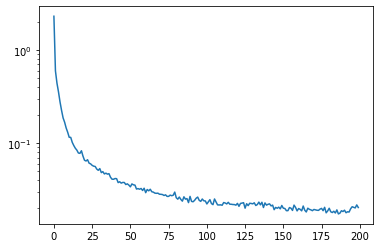

In [56]:
r = 10 # order of sparse LU preconditioner
step_size = 0.05
grad_norm_clip_thr = 1e0    # if diverges, try gradient clipping  
         
with tf.Session() as sess:
    num_para = sum([np.prod(W.shape.as_list()) for W in Ws])
    # lower triangular matrix is [L1, 0; L2, diag(l3)]; L12 is [L1; L2]
    L12 = tf.Variable(tf.concat([tf.eye(r, dtype=dtype),
                                 tf.zeros([num_para - r, r], dtype=dtype)], axis=0), trainable=False)
    l3 = tf.Variable(tf.ones([num_para - r, 1], dtype=dtype), trainable=False)
    # upper triangular matrix is [U1, U2; 0, diag(u3)]; U12 is [U1, U2]
    U12 = tf.Variable(tf.concat([tf.eye(r, dtype=dtype),
                                 tf.zeros([r, num_para - r], dtype=dtype)], axis=1), trainable=False)
    u3 = tf.Variable(tf.ones([num_para - r, 1], dtype=dtype), trainable=False)
        
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = psgd.precond_grad_splu(L12, l3, U12, u3, grads)
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)]) # dot(grads, delta_Ws)
    hess_deltaw = tf.gradients(grad_deltaw, Ws) # Hessian * delta_Ws
    
    new_L12, new_l3, new_U12, new_u3 = psgd.update_precond_splu(L12, l3, U12, u3, delta_Ws, hess_deltaw)
    update_Q = [tf.assign(L12, new_L12), tf.assign(l3, new_l3),
                tf.assign(U12, new_U12), tf.assign(u3, new_u3)]
    
    test_loss = test_criterion(Ws)  
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches()
    
        t0 = time.time()
        _train_loss, _,_ = sess.run([train_loss, update_Ws, update_Q],
                                    {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1],np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/splu_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SCAN preconditioning

train loss: 2.330400228500366; test loss: 2.291217088699341; Time:0.45142507553100586
train loss: 1.4216868399083622; test loss: 0.6149940490722656; Time:1.7985906600952148
train loss: 1.0979268089877476; test loss: 0.48749276995658875; Time:3.139247417449951
train loss: 0.9282160226538246; test loss: 0.428589403629303; Time:4.491239547729492
train loss: 0.7986616388613099; test loss: 0.3878050148487091; Time:5.829512596130371
train loss: 0.7243845492884446; test loss: 0.34366148710250854; Time:7.164540529251099
train loss: 0.6497866857357675; test loss: 0.31056806445121765; Time:8.52930235862732
train loss: 0.5811286633643746; test loss: 0.276749849319458; Time:9.869531393051147
train loss: 0.5186163713733841; test loss: 0.24827930331230164; Time:11.212675094604492
train loss: 0.4664488911610529; test loss: 0.22437573969364166; Time:12.540834426879883
train loss: 0.41802578941047286; test loss: 0.20086218416690826; Time:13.870767593383789
train loss: 0.37483019200574164; test loss: 0.

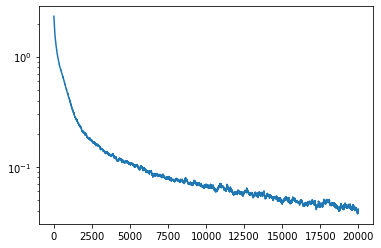

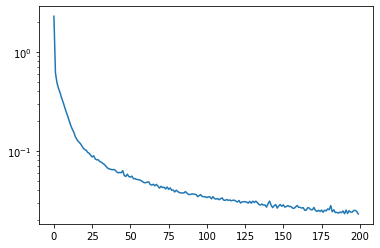

In [57]:
step_size = 0.05
grad_norm_clip_thr = 1e0 # may be necessary for RNN training; otherwise, set it to an arbitrarily large value or inf  

with tf.Session() as sess:   
    # first rows define the diagonal part; must be positive numbers
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),
                                      tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, dtype=dtype) for W in Ws]
    grad_deltaw = tf.reduce_sum([tf.reduce_sum(g*v) for (g, v) in zip(grads, delta_Ws)])
    hess_deltaw = tf.gradients(grad_deltaw, Ws)
    
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, hess_deltaw)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))

    
plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# PSGD with SCAN preconditioning (Approximated Hv Product)

train loss: 2.3244845867156982; test loss: 2.297987222671509; Time: 0.4365882873535156
train loss: 1.4293974585652354; test loss: 0.6284191608428955; Time: 1.5240845680236816
train loss: 1.1073381812587475; test loss: 0.4876200556755066; Time: 2.568718671798706
train loss: 0.9187633280694212; test loss: 0.43180233240127563; Time: 3.6165804862976074
train loss: 0.7920252218665702; test loss: 0.38455265760421753; Time: 4.684248208999634
train loss: 0.7095920094268161; test loss: 0.3472318947315216; Time: 5.746046543121338
train loss: 0.64943298416901; test loss: 0.31642237305641174; Time: 6.798794269561768
train loss: 0.5868442564498804; test loss: 0.2800160348415375; Time: 7.863286256790161
train loss: 0.5301685394302185; test loss: 0.2523655891418457; Time: 8.920296430587769
train loss: 0.47435205608585784; test loss: 0.22835952043533325; Time: 9.982282876968384
train loss: 0.4170373110021263; test loss: 0.20213288068771362; Time: 11.041845321655273
train loss: 0.38133031852768684; tes

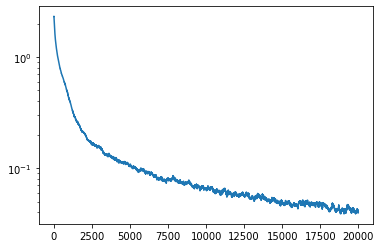

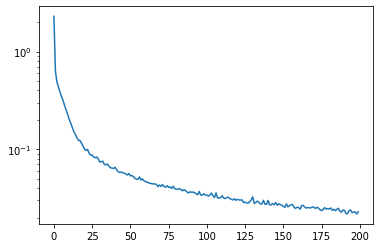

In [58]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    # first rows define the diagonal part; must be positive numbers 
    qs_left = [tf.Variable(tf.concat([tf.ones((1, W.shape.as_list()[0])),
                                      tf.zeros((1, W.shape.as_list()[0]))], axis=0), trainable=False) for W in Ws]
    qs_right = [tf.Variable(tf.ones((1, W.shape.as_list()[1])), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)
    
    precond_grads = [psgd.precond_grad_scan(ql, qr, g) for (ql, qr, g) in zip(qs_left, qs_right, grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    new_Ws = [W - (step_size_adjust*step_size)*g for (W, g) in zip(Ws, precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_qs = [psgd.update_precond_scan(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(qs_left, qs_right, delta_Ws, delta_grads)]
    update_qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(qs_left, qs_right, new_qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
    
        t0 = time.time()
        _train_loss, _, _ = sess.run([train_loss, update_Ws, update_qs],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}; Time: {}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond_approx.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Kronecker Product + ADAM

train loss: 2.3340606689453125; test loss: 2.299431324005127, time:0.38117432594299316
train loss: 1.2529691045165068; test loss: 0.3950769007205963, time:1.6636109352111816
train loss: 0.7667782635460147; test loss: 0.1761944591999054, time:2.9462246894836426
train loss: 0.4377289365711516; test loss: 0.1003689095377922, time:4.2343902587890625
train loss: 0.25740163395906773; test loss: 0.06878641992807388, time:5.536664724349976
train loss: 0.16797093253103632; test loss: 0.0547010637819767, time:6.836666584014893
train loss: 0.11980427104280264; test loss: 0.046230901032686234, time:8.12494158744812
train loss: 0.09577446854569298; test loss: 0.041796378791332245, time:9.456664323806763
train loss: 0.0797168059690416; test loss: 0.03805070370435715, time:10.791468620300293
train loss: 0.06966887466897803; test loss: 0.03474031016230583, time:12.141765832901001
train loss: 0.06812268744735904; test loss: 0.032723765820264816, time:13.489702463150024
train loss: 0.059100627418861636;

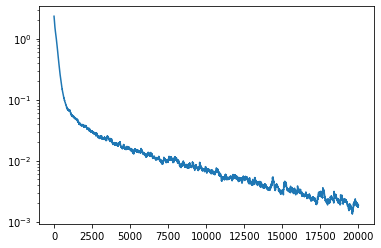

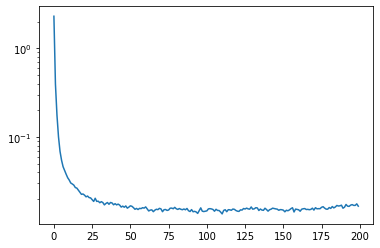

In [59]:
step_size = 0.05
grad_norm_clip_thr = 1e0   # gradients clipping may be necessary for RNN training; 
                            # set it to an extremely large value if no clipping is required   
beta1 = 0.9
beta2 = 0.999
offset = 1e-9

with tf.Session() as sess:   
    eps = max([np.finfo(W.dtype.as_numpy_dtype).eps for W in Ws])
    
    grads_vars = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]
    grads_moment = [tf.Variable(tf.zeros(W.shape, dtype=dtype), trainable=False) for W in Ws]

    Qs_left = [tf.Variable(tf.eye(W.shape.as_list()[0], dtype=dtype), trainable=False) for W in Ws]
    Qs_right = [tf.Variable(tf.eye(W.shape.as_list()[1], dtype=dtype), trainable=False) for W in Ws]
    
    train_loss = train_criterion(Ws)
    grads = tf.gradients(train_loss, Ws)

    new_grads_moment = [beta1*old + (1.0 - beta1)*new for (old, new) in zip(grads_moment, grads)]
    new_grads_vars = [beta2*old + (1.0 - beta2)*new*new for (old, new) in zip(grads_vars, grads)]
    new_grads_moment_hat = [m/(1-beta1**adam_step) for m in new_grads_moment]
    new_grads_vars_hat = [v/(1-beta2**adam_step) for v in new_grads_vars]

    adam_grads = [m/tf.sqrt(v + offset) for (m,v) in zip(new_grads_moment_hat,new_grads_vars_hat)]

    precond_grads = [psgd.precond_grad_kron(ql, qr, g) for (ql, qr, g) in zip(Qs_left, Qs_right, adam_grads)]
    grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(g*g) for g in precond_grads]))
    step_size_adjust = tf.minimum(1.0, grad_norm_clip_thr/(grad_norm + 1.2e-38))
    
    new_Ws = [W - (step_size_adjust*step_size)*pG for (W, pG) in zip(Ws,precond_grads)]
    update_Ws = [tf.assign(W, new_W) for (W, new_W) in zip(Ws, new_Ws)]
    
    update_grads_vars = [tf.assign(old, new) for (old, new) in zip(grads_vars, new_grads_vars)]
    update_grads_moment = [tf.assign(old, new) for (old, new) in zip(grads_moment, new_grads_moment)]
    
    delta_Ws = [tf.random_normal(W.shape, mean=0.0, stddev=tf.sqrt(eps), dtype=dtype) for W in Ws]
    perturbed_Ws = [W + d for (W, d) in zip(Ws, delta_Ws)]
    perturbed_grads = tf.gradients(train_criterion(perturbed_Ws), Ws)
    delta_grads = [g1 - g0 for (g1, g0) in zip(perturbed_grads, grads)]
    
    new_Qs = [psgd.update_precond_kron(ql, qr, dw, dg) for (ql, qr, dw, dg) in zip(Qs_left, Qs_right, delta_Ws, delta_grads)]
    update_Qs = [[tf.assign(old_ql, new_q[0]), tf.assign(old_qr, new_q[1])] for (old_ql, old_qr, new_q) in zip(Qs_left, Qs_right, new_Qs)]
    
    test_loss = test_criterion(Ws)     
    
    sess.run(tf.global_variables_initializer())
    avg_train_loss = 0.0
    TrainLoss = list()
    TestLoss = list()
    Time = list()
    t = 0
    for num_iter in range(20000):    
        _train_inputs, _train_outputs = get_batches( )
        t = t + 1
        t0 = time.time()
        _train_loss, _, _,_,_ = sess.run([train_loss, update_Ws, update_Qs,update_grads_moment, update_grads_vars],
                                     {train_inputs: _train_inputs, train_outputs: _train_outputs, adam_step: t})
        Time.append(time.time() - t0)
        nu = min(num_iter/(1.0 + num_iter), 0.99)
        avg_train_loss = nu*avg_train_loss + (1.0 - nu)*_train_loss
        TrainLoss.append(avg_train_loss)      
        if num_iter % 100 == 0:
            _test_loss = sess.run(test_loss)
            TestLoss.append(_test_loss)
            print('train loss: {}; test loss: {}, time:{}'.format(TrainLoss[-1], TestLoss[-1], np.sum(Time)))


plt.figure(1)
plt.semilogy(TrainLoss)
plt.figure(2)
plt.semilogy(TestLoss)

  
scipy.io.savemat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_adam.mat', {'TrainLoss': TrainLoss, 'TestLoss': TestLoss, 'Time':Time})

# Comparison of All above second order approximations

In [0]:
sgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/SGD.mat')
adam = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/adam.mat')
adam_kron = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_adam.mat')
rmsprop = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/rmsprop.mat')
esgd = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/ESGD.mat')
kron_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond.mat')
kron_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/kron_precond_approx.mat')
splu = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/splu_precond.mat')
scan_precond = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond.mat')
scan_precond_approx = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/MS Thesis/Preconditioned SGD/MNIST/results/scan_precond_approx.mat')

In [0]:
sgd_time = sgd.get('Time').reshape(20000,)
adam_time = adam.get('Time').reshape(20000,)
rmsprop_time = rmsprop.get('Time').reshape(20000,)
esgd_time = esgd.get('Time').reshape(20000,)
kron_time =  kron_precond.get('Time').reshape(20000,)
kron_approx_time = kron_precond_approx.get('Time').reshape(20000,)
splu_time = splu.get('Time').reshape(20000,)
scan_time = scan_precond.get('Time').reshape(20000,)
scan_approx_time = scan_precond_approx.get('Time').reshape(20000,)
adam_kron_time = adam_kron.get('Time').reshape(20000,)


In [0]:
sgd_TrainLoss = sgd.get('TrainLoss').reshape(20000,)
adam_TrainLoss = adam.get('TrainLoss').reshape(20000,)
rmsprop_TrainLoss = rmsprop.get('TrainLoss').reshape(20000,)
esgd_TrainLoss = esgd.get('TrainLoss').reshape(20000,)
kron_TrainLoss =  kron_precond.get('TrainLoss').reshape(20000,)
kron_approx_TrainLoss = kron_precond_approx.get('TrainLoss').reshape(20000,)
splu_TrainLoss = splu.get('TrainLoss').reshape(20000,)
scan_TrainLoss = scan_precond.get('TrainLoss').reshape(20000,)
scan_approx_TrainLoss = scan_precond_approx.get('TrainLoss').reshape(20000,)
adam_kron_TrainLoss = adam_kron.get('TrainLoss').reshape(20000,)

In [0]:
sgd_TestLoss = sgd.get('TestLoss').reshape(200,)
adam_TestLoss = adam.get('TestLoss').reshape(200,)
rmsprop_TestLoss = rmsprop.get('TestLoss').reshape(200,)
esgd_TestLoss = esgd.get('TestLoss').reshape(200,)
kron_TestLoss =  kron_precond.get('TestLoss').reshape(200,)
kron_approx_TestLoss = kron_precond_approx.get('TestLoss').reshape(200,)
splu_TestLoss = splu.get('TestLoss').reshape(200,)
scan_TestLoss = scan_precond.get('TestLoss').reshape(200,)
scan_approx_TestLoss = scan_precond_approx.get('TestLoss').reshape(200,)
adam_kron_TestLoss = adam_kron.get('TestLoss').reshape(200,)


In [65]:
optimizers = ['SGD','adam', 'RMSprop', 'ESGD', 'kron', 'kron_approx', 'SPLU', 'SCAN', 'SCAN_approx','hybrid_ADAMKRON']
training_time = [np.sum(sgd_time),np.sum(adam_time), np.sum(rmsprop_time), np.sum(esgd_time), np.sum(kron_time),
                 np.sum(kron_approx_time),np.sum(splu_time), np.sum(scan_time), np.sum(scan_approx_time),np.sum(adam_kron_time)]
print(tabulate(zip(optimizers, training_time),headers = ['optimizers','time (sec)']))

optimizers         time (sec)
---------------  ------------
SGD                   101.09
adam                  113.066
RMSprop               109.932
ESGD                  244.921
kron                  302.14
kron_approx           246.042
SPLU                  258.516
SCAN                  269.784
SCAN_approx           213.326
hybrid_ADAMKRON       266.193


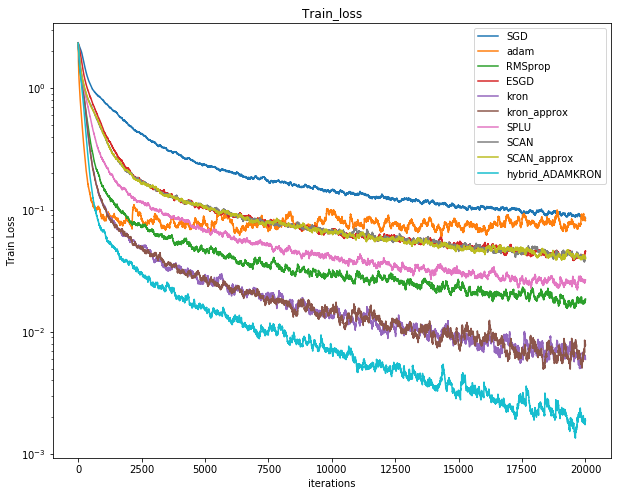

In [66]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TrainLoss)
plt.semilogy(adam_TrainLoss)
plt.semilogy(rmsprop_TrainLoss)
plt.semilogy(esgd_TrainLoss)
plt.semilogy(kron_TrainLoss)
plt.semilogy(kron_approx_TrainLoss)
plt.semilogy(splu_TrainLoss)
plt.semilogy(scan_TrainLoss)
plt.semilogy(scan_approx_TrainLoss)
plt.semilogy(adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('iterations')
plt.ylabel('Train Loss')
plt.legend(optimizers)

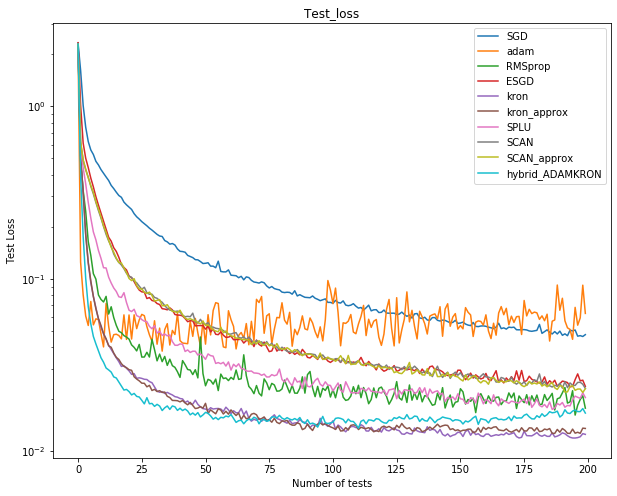

In [67]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_TestLoss)
plt.semilogy(adam_TestLoss)
plt.semilogy(rmsprop_TestLoss)
plt.semilogy(esgd_TestLoss)
plt.semilogy(kron_TestLoss)
plt.semilogy(kron_approx_TestLoss)
plt.semilogy(splu_TestLoss)
plt.semilogy(scan_TestLoss)
plt.semilogy(scan_approx_TestLoss)
plt.semilogy(adam_kron_TestLoss)

plt.title('Test_loss')
plt.xlabel('Number of tests')
plt.ylabel('Test Loss')
plt.legend(optimizers)


In [0]:
sgd_t = np.cumsum(sgd_time)
adam_t =  np.cumsum(adam_time)
rmsprop_t = np.cumsum(rmsprop_time)
esgd_t = np.cumsum(esgd_time)
kron_t =  np.cumsum(kron_time)
kron_approx_t = np.cumsum(kron_approx_time)
splu_t = np.cumsum(splu_time)
scan_t = np.cumsum(scan_time)
scan_approx_t =np.cumsum(scan_approx_time)
adam_kron_t =  np.cumsum(adam_kron_time)

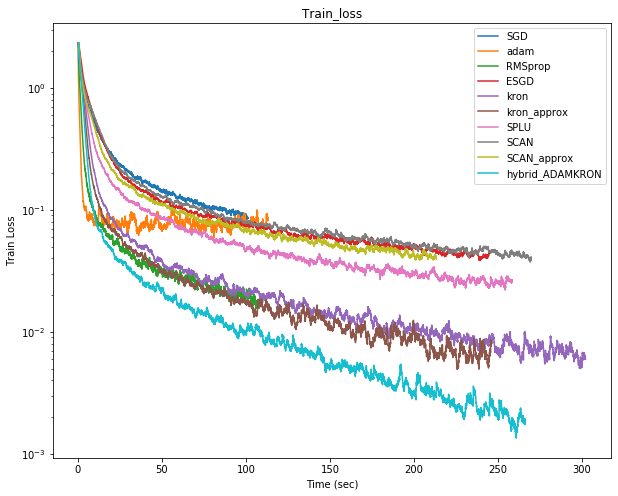

In [69]:
fig = plt.figure(figsize=(10,8))

plt.semilogy(sgd_t,sgd_TrainLoss)
plt.semilogy(adam_t,adam_TrainLoss)
plt.semilogy(rmsprop_t,rmsprop_TrainLoss)
plt.semilogy(esgd_t,esgd_TrainLoss)
plt.semilogy(kron_t, kron_TrainLoss)
plt.semilogy(kron_approx_t, kron_approx_TrainLoss)
plt.semilogy(splu_t, splu_TrainLoss)
plt.semilogy(scan_t, scan_TrainLoss)
plt.semilogy(scan_approx_t, scan_approx_TrainLoss)
plt.semilogy(adam_kron_t,adam_kron_TrainLoss)

plt.title('Train_loss')
plt.xlabel('Time (sec)')
plt.ylabel('Train Loss')
plt.legend(optimizers)
# plt.ylim([0,0.5])